# Social Graphs 2021 - Assignment 2
## Quick disclaimer
The assignment description could hint at not implementing some of the previous exercises, but just use the files already downloaded and processed. This seemed to make the exercises and explanations a little incoherrent, so we have included the code for the API-calls and other misc stuff. We have tried to collapse the cell blocks, so this is not annoying for the reader, but if they do appear, sorry for the inconvinience.

In [8]:
# Imports
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import wordcloud
import nltk
import networkx as nx

import re
import json
import urllib

import seaborn as sns
import os

import powerlaw

In [142]:
# Styles and data. If this cell block is not already hidden/minimized, feel free to do so, as it only contains the styles for the plots, 
# and the characters.csv in written form, as it allows for reruns of the code, if needed.
DTU_COLORS_HEX = dict(
    dtured      = "#990000",
    blue        = "#2F3EEA",
    brightgreen = "#1FD082",
    navyblue    = "#030F4F",
    yellow      = "#F6D04D",
    orange      = "#FC7634",
    pink        = "#F7BBB1",
    grey        = "#DADADA",
    red         = "#E83F48",
    green       = "#008835",
    purple      = "#79238E"
)

def hex_to_rgb(hex: str):
    hex = hex.replace("#", "")
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

DTU_COLORS_RGB = [hex_to_rgb(x) for x in DTU_COLORS_HEX.values()]
dtu_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("dtu_colors", DTU_COLORS_RGB, N=100)

cmap = sns.color_palette("Spectral", as_cmap=True)
colors = list(DTU_COLORS_HEX.values())

sns.set()
sns.set_palette("Spectral")


default = dict(
    figsize     = (20, 5),
)

big_plot = dict(
    figsize     = (20, 20),
)

# 0. Building the network
As this process is a two step of finding names, and then their pages, we have shuffled the explanation of strategy and regular expressions

## Strategy for extracting hyperlinks from the wiki-pages
### Downloading
First we download the three wiki pages containing the ally, enemy and boss characters. From this we use a regular expression to find all character names.
### Regex
First the boss page has an edge case, where the location of the boss is included in the same format, as the name of the boss. To remove this, we use ```{{Small.*?''}}``` to find the locations and remove them.

When these are removed we use ```({{Term\|BotW\|(.*?)\|link[\|]*.*?}})``` to find the names of each character. All names follow the same convention of `{{Term|BotW|NAME OF CHARACTER|link|MAYBE MORE STUFF}}` occasionally followed by further information. This is solved by using `*.*?` which lazily finds additional terms. `*?` makes sure, that this is only done until the following character `}` is found.

## Strategy for finding gender and race
As we already have the character pages, we do a regex expression for gender, and for race.

* Race: `{{Infobox.*?\|(?:race=|species=)\s(.*?)(?:\n|<ref).*?(?:\|gender=\s`**(.*?)**`(?:\n|<ref)|).*?}}`. 

For each character page we use this expression. All metainformation, including the races, is contained in an Infobox, explaining the beginning and end of the expressions. We use capture groups to allow for or-statements signified by `(|)` the |-symbol, as this cannot be written outside of a capture group. As whether the keyword is `race` or `species` is not important `(?:)` is used, to make the capture group not return anything. The same convention is followed throughout the expression, to include different types of definitions. Lastly the small group `(.*?)` is used to find the race of the character. Characters might have multiple races, in which case only the first is chosen.

* Gender: `.*(Male|Female).*`. 

Genders are only included inside of infoboxes, which we found in the previous expression. Using the extraction from the previous expression this expression is now used. This expression is only run for these infoboxes. The expression is only used on these, searching for males or females, where the `|`-symbol signifies an or-statement. For genders outside of male or female, the gender `unknown` is assigned to the character. 

From here we do an API-call using the character names to get each characters content. Then we use the regular the same set of regular expressions for each character extracting the links to other characters.

## Strategy for extracting links to characters
Curly and square bracket

# 1. Network visualization and basic stats
## Preliminary
The code below finds the character links using the regex expressions previosly discussed, and extracts the giant component using networkx.

In [3]:
df = pd.read_csv("Characters.csv")

import networkx as nx

G = nx.DiGraph()
for _, (name, role, race, gender) in df.iterrows():
    G.add_node(name, role=role, race=race, gender=gender)

# Expressions
brackets_pattern = r'\[\[(.*?)(?:\|.*?|\#.*?)?\]\]'
curly_pattern =    r'{{(?:Term|Plural)\|.*?\|(.*?)(?:\|.*?)?}}'

for name in df.Name:
    description = open(f"././Characters/{name}.txt", "r", encoding="utf-8").read()
    links = []
    links.extend(re.findall(brackets_pattern, description))
    links.extend(re.findall(curly_pattern, description))
    for link in links:
        if link in df.Name.values and link != name:
            G.add_edge(name, link)

GCC = G.subgraph(max(nx.weakly_connected_components(G), key=len))

print(f"Number of nodes in network: \t {GCC.number_of_nodes()}")
print(f"Number of links🔗: \t\t {GCC.number_of_edges()}")

sorted_in  = sorted(GCC.nodes, key=GCC.in_degree, reverse=True)
sorted_out = sorted(GCC.nodes, key=GCC.out_degree, reverse=True)
sorted_tot = sorted(GCC.nodes, key=GCC.degree, reverse=True)

print(f"Most connected in:\t {sorted_in[0]}\n\tin👈:\t{GCC.in_degree(sorted_in[0])}\n\tout👉:\t{GCC.out_degree(sorted_in[0])}")
print(f"Most connected out:\t {sorted_out[0]}\n\tin👈:\t{GCC.in_degree(sorted_out[0])}\n\tout👉:\t{GCC.out_degree(sorted_out[0])}")
print(f"Most connected overall:\t {sorted_tot[0]}\n\tin👈:\t{GCC.in_degree(sorted_tot[0])}\n\tout👉:\t{GCC.out_degree(sorted_tot[0])}")

allies = df[df.Role=="Ally"].Name.to_list()
enemies = df[df.Role.isin(["Enemy", "Boss"])].Name.to_list()

sorted_allies = list(filter(lambda x: x in allies, sorted_tot))
sorted_enemies = list(filter(lambda x: x in enemies, sorted_tot))

# Seems a bit long to show same result as above for all allies and enemies,
# so here we only look at total degree
print("Most connected allies (name, in, out) ✌")
print("\t"+"\n\t".join([", ".join([str(x), str(GCC.in_degree(x)), str(GCC.out_degree(x))]) for x in sorted_allies[:5]]))
print("Most connected enemies (name, in, out) 😈")
print("\t"+"\n\t".join([", ".join([str(x), str(GCC.in_degree(x)), str(GCC.out_degree(x))]) for x in sorted_enemies[:5]]))


Number of nodes in network: 	 520
Number of links🔗: 		 1741
Most connected in:	 Link
	in👈:	391
	out👉:	9
Most connected out:	 Traysi
	in👈:	2
	out👉:	14
Most connected overall:	 Link
	in👈:	391
	out👉:	9
Most connected allies (name, in, out) ✌
	Link, 391, 9
	Hylia, 67, 3
	Princess Zelda, 32, 7
	Riju, 23, 5
	Purah, 17, 8
Most connected enemies (name, in, out) 😈
	Calamity Ganon, 101, 8
	Bokoblin, 20, 10
	Lizalfos, 11, 13
	Moblin, 10, 12
	Stalizalfos, 9, 12


## Stats
Number of nodes, and links can be seen above.

## Most connected character.
Link being the most overall connected character is not suprising, as he is the main character of the franchise. It did however suprise us a bit, that he is not the most out-wards connected character, and Traysi is instead. After reading about her, it makes sense, as she has a quest where Link has to talk to different people, and all of these people are all linked on her page, which is of course not mentioned on Links page as it is quite a small quest, but all of it is mentioned on her page, as that is most of her role in the game.

## Mostly connected allies and enemies
For the allies it is more or less what was expected, as all the characters that appear in the top 5 are main characters. For the enemies its a bit confusing, as all other characters than Calamity Ganon are not characters, but instead generic enemies. It does however make sense, that they are in the top 5, as they are commonly occurring.

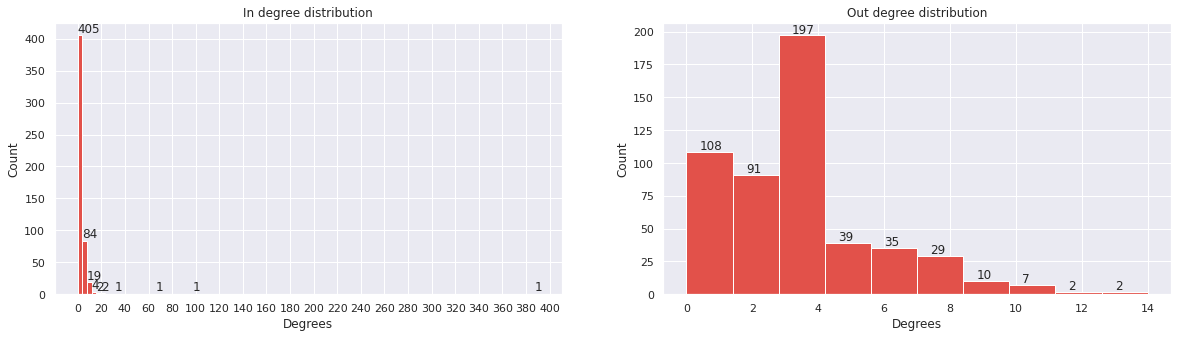

In [7]:
fig, (in_ax, out_ax) = plt.subplots(1, 2, **default)
in_degrees = dict(GCC.in_degree()).values()
out_degrees = dict(GCC.out_degree()).values()

counts, bins, bars = in_ax.hist(in_degrees, bins=100)
in_ax.set_title("In degree distribution")
in_ax.set_xlabel("Degrees")
in_ax.set_ylabel("Count")
in_ax.set_xticks(np.arange(0, 420, step=20))

for c, b in zip(counts, bins):
    if c > 0: in_ax.text(b, c+5, f"{c:.0f}")


counts, bins, bars = out_ax.hist(out_degrees)
out_ax.set_title("Out degree distribution")
out_ax.set_xlabel("Degrees")
out_ax.set_ylabel("Count")

for c, b in zip(counts, bins):
    if c > 0: out_ax.text(b+.4, c+2, f"{c:.0f}")

## In-degree and out-degree distributions 

The first apparent difference that one can see is that for the in-degree distribution, there is one big outielr that skews the plot a lot (Link). To fully explain the differences, it's necessary to use more bins in the in degree distribution plot.

Once that is done, it is clear that most characters have an in degree very small (between 0 and 5). That does make sense, because most secondary characters do not have external references in other character wikis, only the main characters. The Link outlier makes sense too, as is the main characters, and most wiki pages make reference to him.

On the other hand, the out degree is more spread, without outliers. Most characters do make a few references in their wiki to other characters, and only a small percentage of the have a lot of out degree links.

In [49]:
in_degree = [d for n, d in GCC.in_degree() if d > 0]
out_degree = [d for n, d in GCC.out_degree() if d > 0]

results_in = powerlaw.Fit(in_degree, xmin=1)
results_out = powerlaw.Fit(out_degree, xmin=1)

In [50]:
print(f"Exponent of the degree distribution for the in-degree:\t {results_in.alpha}")
print(f"Exponent of the degree distribution for the out-degree:\t {results_out.alpha}")

Exponent of the degree distribution for the in-degree:	 2.0968769070278466
Exponent of the degree distribution for the out-degree:	 1.9179618614179939


## Exponent of the degree distributions

As shown in the previous calculations with the `powerlaw` package, the degree exponent for the in-degree distribution is a bit higher than `2.09`, which would fit in the *Scale-Free Regime*. That means that this degree distributions follows an scale free distribution.

Meanwhile, the degree exponent for the out-degree distribution is under `2.0` so it belongs to the *Anomalous Regime*. That means that he number of links connected to the largest hub grows faster than the size of the network. So eventualy, with more nodes, it wouyld become an scale free distribution.

In [82]:
num_nodes = len(GCC.nodes)
prob_edge = (2 * len(GCC.edges)/num_nodes)/(num_nodes - 1)


random_g = nx.generators.random_graphs.erdos_renyi_graph(n=num_nodes, p=prob_edge)
print(f"Random network generated with {len(random_g.nodes)} nodes and {len(random_g.edges)} links")

Random network generated with 520 nodes and 1798 links


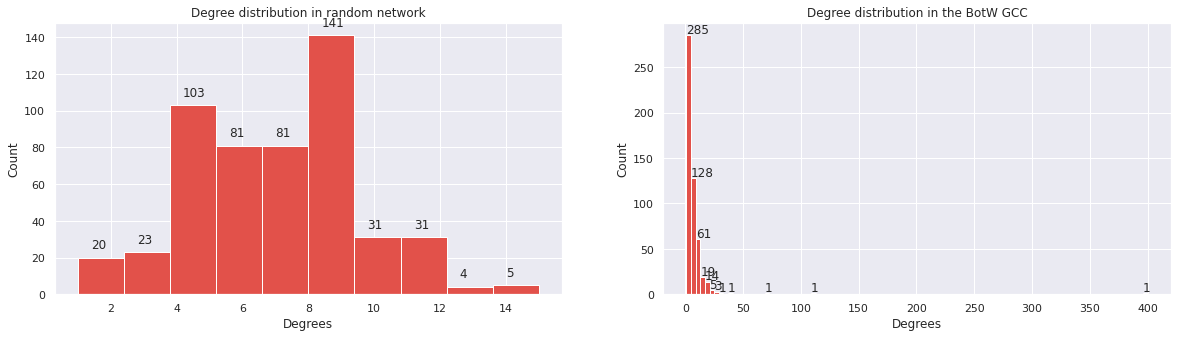

In [89]:
fig, (rand_ax, gcc_ax) = plt.subplots(1, 2, **default)
random_degrees = dict(random_g.degree()).values()
GCC_degrees = dict(GCC.degree()).values()

counts, bins, bars = rand_ax.hist(random_degrees)
rand_ax.set_title("Degree distribution in random network")
rand_ax.set_xlabel("Degrees")
rand_ax.set_ylabel("Count")

for c, b in zip(counts, bins):
    if c > 0: rand_ax.text(b+.4, c+5, f"{c:.0f}")

counts, bins, bars = gcc_ax.hist(GCC_degrees, bins=100)
gcc_ax.set_title("Degree distribution in the BotW GCC")
gcc_ax.set_xlabel("Degrees")
gcc_ax.set_ylabel("Count")

for c, b in zip(counts, bins):
    if c > 0: gcc_ax.text(b, c+2, f"{c:.0f}")

## Degree distribution comparison

As expected, the degree distribution in a random network follows a Poisson distribution, while the degree distribution of the BotW GCC follows an scale free distribution, or a least is much closer to that distribution.


EXPLAIN MORE STUFF HERE, I DON'T KNOW WHAT TO PUT

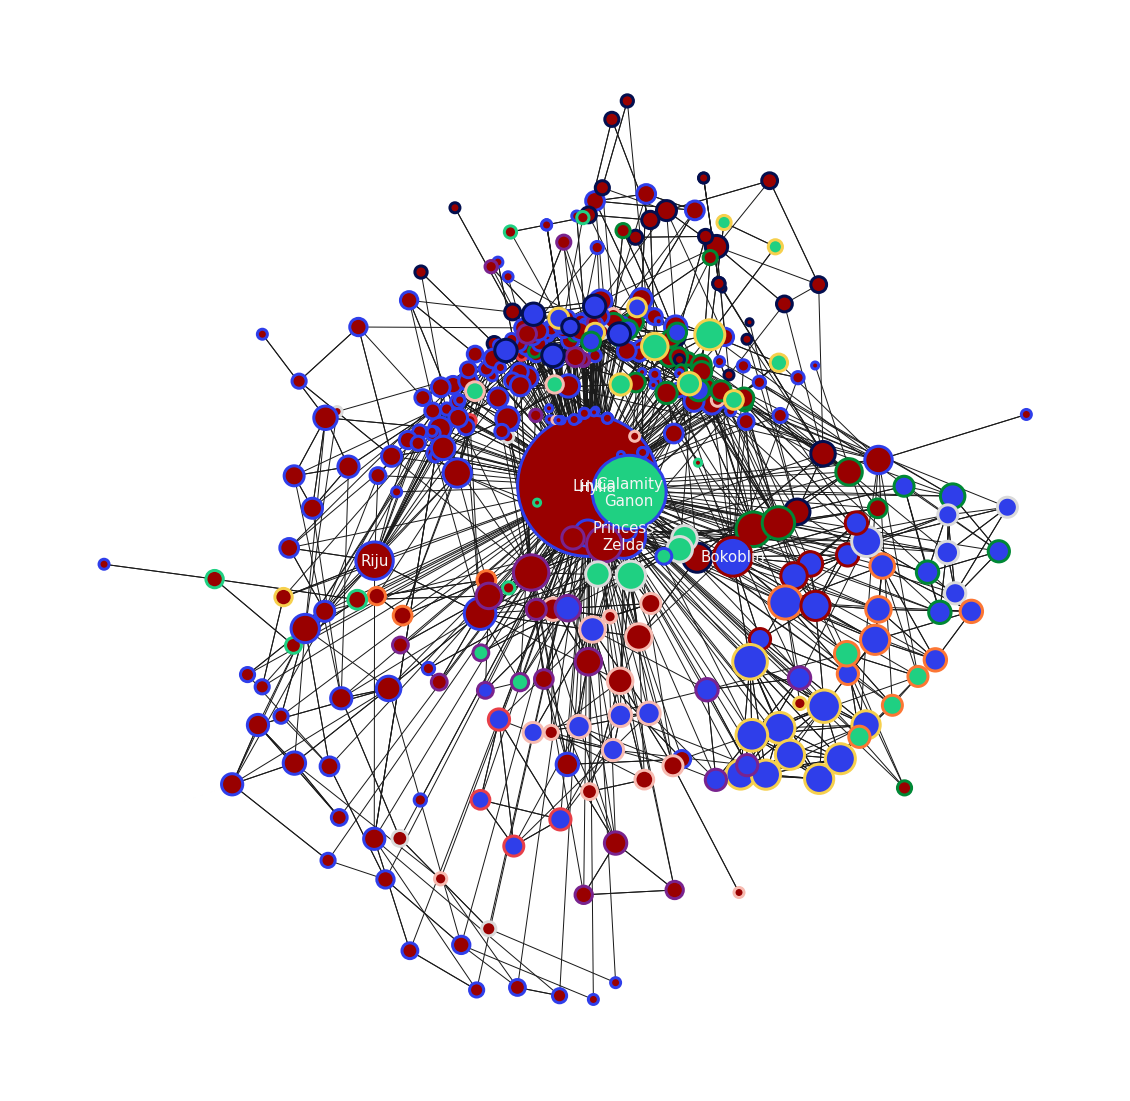

In [143]:
plt.figure(**big_plot)
plt.plot()

color_role = dict(
  Ally  = DTU_COLORS_HEX["dtured"],
  Enemy = DTU_COLORS_HEX["blue"],
  Boss  = DTU_COLORS_HEX["brightgreen"]
)

color_race = {
  "Hylian"         : DTU_COLORS_HEX["blue"], 
  "Horse"          : DTU_COLORS_HEX["brightgreen"],
  "Goron"          : DTU_COLORS_HEX["navyblue"],
  "Human"          : DTU_COLORS_HEX["yellow"],
  "Dragon"         : DTU_COLORS_HEX["orange"], 
  "Rito"           : DTU_COLORS_HEX["pink"],
  "Unknown"        : DTU_COLORS_HEX["grey"],
  "Korok"          : DTU_COLORS_HEX["red"],
  "Zora"           : DTU_COLORS_HEX["green"],
  "Sheikah"        : DTU_COLORS_HEX["purple"],
  "Gerudo"         : DTU_COLORS_HEX["blue"],
  "Great Fairy"    : DTU_COLORS_HEX["brightgreen"],
  "Ancient Orb"    : DTU_COLORS_HEX["navyblue"],
  "Sand Seal"      : DTU_COLORS_HEX["yellow"],
  "Dog"            : DTU_COLORS_HEX["orange"],
  "Bokoblin"       : DTU_COLORS_HEX["dtured"],  
  "Lizalfos"       : DTU_COLORS_HEX["yellow"],
  "Moblin"         : DTU_COLORS_HEX["orange"],
  "Wizzrobe"       : DTU_COLORS_HEX["pink"],
  "Lynel"          : DTU_COLORS_HEX["grey"],
  "Chuchu"         : DTU_COLORS_HEX["red"],
  "Guardian"       : DTU_COLORS_HEX["green"],
  "Keese"          : DTU_COLORS_HEX["purple"],
  "Octorok"        : DTU_COLORS_HEX["navyblue"],
  "Talus"          : DTU_COLORS_HEX["yellow"],
  "Hinox"          : DTU_COLORS_HEX["orange"],
  "Molduga"        : DTU_COLORS_HEX["pink"]
}



scale = 50

min_size = 25

node_info = list()
labels = dict()

for node, node_data in list(GCC.nodes(data=True)):
  
  color = color_role[node_data["role"]]
  size = GCC.degree(node)*scale
  border_color = color_race[node_data["race"]]
  
  labels[node] = ""
  
  if GCC.degree(node) > min_size:
    labels[node] = node.replace(" ", "\n")
  
  node_info.append((node, color, size, border_color))
  
nx.draw_kamada_kawai(GCC,
                     arrowstyle  = "-",
                     edgecolors  = [x[3] for x in node_info],
                     linewidths  = 3,
                     node_color  = [x[1] for x in node_info],
                     node_size   = [x[2] for x in node_info],
                     labels      = labels,
                     with_labels = True,
                     font_size   = 15,
                     font_color  = "whitesmoke"
                    )
  
plt.show()

## Visualization

DONT KNOW WHAT TO DO. CAN'T USE fa2 SO CANNOT PLACE IT IN A GOOD WAY

```
  Color of the node   -> Role
  Size of the node    -> Degree
  Color of the border -> Race
  Labels              -> Have high degree

```

As expected, the biggest node is that of 'Link', as is the one most connected. Other big nodes that can be seen are 'Calamity Ganon' or 'Princess Zelda', as they are central elements in the game.

Other thing that can be seen quite clearly with the graph is that bosses and enemies tend to be referenced together, as they have many links between them. Same happens with the allies. Of course, some nodes that are allies are connected to enemies.

About the connections between nodes, we can see that most nodes are connected to other nodes of the same race, wich makes sense, as in the game, character of the same race are in the same areas, so they make references to other characters of the same area.


*Side note: The coloring by race is not perfect, as some color are repeating, but it helps in the general visualization*